In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from random import normalvariate
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy import fftpack,signal
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.special import jv
from scipy import interpolate, integrate
from scipy.integrate import complex_ode
from scipy import special
from scipy.optimize import curve_fit
from sympy.physics.wigner import wigner_3j ,wigner_6j
#from maxwellbloch import mb_solve, field, ob_atom
import matplotlib as mpl
from scipy.integrate import quad
from scipy.sparse import dok_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
def getRaman1(o1, s1, m1, n1, l1):  # 找 M1 sin(kx) cos(ky) cos(kz) taux sigmax 对应的耦合
    if o1 == 'g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1 == 'down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal = [] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, -1j * 1 / 8),     
            (0, 0, -1, -1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, -1j * 1 / 8),
            (-1, 0, 0, 1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, 1j * 1 / 8),
            (-1, -1, -1, 1j * 1 / 8),
        ]:
            key.append((o2, s2, m1 + dx, n1 + dy, l1 + dz))
            coefffinal.append(coeff * coeffmoment)

    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1 == 'down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal = [] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, -1j * 1 / 8),     
            (1, 1, 0, -1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, -1j * 1 / 8),
            (0, 1, 1, 1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, 1j * 1 / 8),
            (0, 0, 0, 1j * 1 / 8),
        ]:
            key.append((o2, s2, m1 + dx, n1 + dy, l1 + dz))
            coefffinal.append(coeff * coeffmoment)

    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    
    return key, coefffinal

    
def getRaman2(o1,s1,m1,n1,l1): #找 -M1 cos(kx) sin(ky) cos(kz) taux sigmay 对应的耦合
    if o1=='g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'down'
            coeff = -1j
        elif s1=='down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, 1j * 1 / 8),     
            (0, 0, -1, 1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, -1j * 1 / 8),
            (-1, 0, 0, 1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, -1j * 1 / 8),
            (-1, -1, -1, -1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)

    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = -1j
        elif s1=='down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, 1j * 1 / 8),     
            (1, 1, 0, 1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, -1j * 1 / 8),
            (0, 1, 1, 1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, -1j * 1 / 8),
            (0, 0, 0, -1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    
    return key,coefffinal

def getRaman3(o1,s1,m1,n1,l1): #找 M2,0 cos(kx) cos(ky) sin(kz) taux sigmaz 对应的耦合
    if o1=='g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, -1j * 1 / 8),     
            (0, 0, -1, 1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, 1j * 1 / 8),
            (-1, 0, 0, -1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, -1j * 1 / 8),
            (-1, -1, -1, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1 
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, -1j * 1 / 8),     
            (1, 1, 0, 1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, 1j * 1 / 8),
            (0, 1, 1, -1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, -1j * 1 / 8),
            (0, 0, 0, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def getRaman4(o1,s1,m1,n1,l1): #找 M2,1 cos(kx) cos(ky) cos(kz) taux sigma0 对应的耦合
    if o1=='g':
        o2='e' #o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0,  1 / 8),     
            (0, 0, -1,  1 / 8),
            (0, -1, 0,  1 / 8),
            (0, -1, -1,  1 / 8),
            (-1, 0, 0,  1 / 8),     
            (-1, 0, -1, 1 / 8),
            (-1, -1, 0,  1/ 8),
            (-1, -1, -1, 1/ 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    elif o1 == 'e':
        o2='g'#o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1,  1 / 8),     
            (1, 1, 0,  1 / 8),
            (1, 0, 1,  1 / 8),
            (1, 0, 0,  1 / 8),
            (0, 1, 1,  1 / 8),     
            (0, 1, 0, 1 / 8),
            (0, 0, 1,  1/ 8),
            (0, 0, 0, 1/ 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def getBasis(numm,numn,numl):
    #q = np.array([qx,qy,qz])  
    truncm = list(range(-numm, numm + 1))
    truncn = list(range(-numn, numn + 1))
    truncl = list(range(-numl, numl + 1))
    basis = []
    index_map = {}
    idx = 0
    for o in ['g', 'e']:
        for s in ['up', 'down']:
            for mx in truncm:
                for ny in truncn:
                    for lz in truncl:
                        basis.append((o, s, mx, ny, lz))
                        index_map[(o, s, mx, ny, lz)] = idx
                        idx += 1
    return basis,index_map

def getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    H = np.zeros((Nb, Nb), dtype=complex)
    #for i, (o1, s1, (m1, n1, l1), (px1, py1, pz1)) in enumerate(basis):
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        # 动能项
        
        if o1 == 'g':
            shift = np.array([0, 0, 0])
        elif o1 == 'e':
            shift = np.array([1, 1, 1])
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        px1 = qx + 2 * m1 + shift[0]
        py1 = qy + 2 * n1 + shift[1]
        pz1 = qz + 2 * l1 + shift[2]
        kinetic = (1/2*px1**2 + 1/2*py1**2 + pz1**2) - 0.5*(V0+V0+Vz) #(0.5*px1**2 + 0.5*py1**2 + pz1**2) - 0.5*(V0+V0+Vz)
        H[i, i] += kinetic

        # Zeeman 项
        if o1 == 'g':
            H[i, i] += delta 
        elif o1 == 'e':
            H[i, i] -= delta 
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        
        for dx in [-1, 1]:
            key = (o1, s1, m1 + dx, n1, l1)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -V0 / 4

        for dy in [-1, 1]:
            key = (o1, s1, m1, n1 + dy, l1)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -V0 / 4

        for dz in [-1, 1]:
            key = (o1, s1, m1, n1, l1 + dz)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -Vz / 4

        key1,coeff1 = getRaman1(o1,s1,m1,n1,l1)
        key2,coeff2 = getRaman2(o1,s1,m1,n1,l1)
        key3,coeff3 = getRaman3(o1,s1,m1,n1,l1)
        key4,coeff4 = getRaman4(o1,s1,m1,n1,l1)

        for keyi1,keyv1 in enumerate(key1):
            j = index_map.get(keyv1)
            if j is not None:
                H[i, j] += M1*coeff1[keyi1]  # 可根据 σ 的结构继续细化

        for keyi2,keyv2 in enumerate(key2):
            j = index_map.get(keyv2)
            if j is not None:
                H[i, j] += M1*coeff2[keyi2]

        for keyi3,keyv3 in enumerate(key3):
            j = index_map.get(keyv3)
            if j is not None:
                H[i, j] += M20*coeff3[keyi3]

        for keyi4,keyv4 in enumerate(key4):
            j = index_map.get(keyv4)
            if j is not None:
                H[i, j] += M21*coeff4[keyi4]
    return H

# 构造电流算符
def CurrentOperatorZ(qz,numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    H = np.zeros((Nb, Nb), dtype=complex)
    #for i, (o1, s1, (m1, n1, l1), (px1, py1, pz1)) in enumerate(basis):
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        # 动能项
        
        if o1 == 'g':
            shift = np.array([0, 0, 0])
        elif o1 == 'e':
            shift = np.array([1, 1, 1])
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        #px1 = qx + 2 * m1 + shift[0]
        #py1 = qy + 2 * n1 + shift[1]
        pz1 = qz + 2 * l1 + shift[2]
        kinetic = (2*pz1*1)  #(0.5*px1**2 + 0.5*py1**2 + pz1**2) - 0.5*(V0+V0+Vz)
        H[i, i] += kinetic
    return H

def CurrentOperatorX(qx,numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    H = np.zeros((Nb, Nb), dtype=complex)
    #for i, (o1, s1, (m1, n1, l1), (px1, py1, pz1)) in enumerate(basis):
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        # 动能项
        
        if o1 == 'g':
            shift = np.array([0, 0, 0])
        elif o1 == 'e':
            shift = np.array([1, 1, 1])
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        px1 = qx + 2 * m1 + shift[0]
        #py1 = qy + 2 * n1 + shift[1]
        #pz1 = qz + 2 * l1 + shift[2]
        kinetic = (px1*1)  #(0.5*px1**2 + 0.5*py1**2 + pz1**2) - 0.5*(V0+V0+Vz)
        H[i, i] += kinetic
    return H


def CurrentOperatorY(qy,numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    H = np.zeros((Nb, Nb), dtype=complex)
    #for i, (o1, s1, (m1, n1, l1), (px1, py1, pz1)) in enumerate(basis):
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        # 动能项
        
        if o1 == 'g':
            shift = np.array([0, 0, 0])
        elif o1 == 'e':
            shift = np.array([1, 1, 1])
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        #px1 = qx + 2 * m1 + shift[0]
        py1 = qy + 2 * n1 + shift[1]
        #pz1 = qz + 2 * l1 + shift[2]
        kinetic = (py1*1)  #(0.5*px1**2 + 0.5*py1**2 + pz1**2) - 0.5*(V0+V0+Vz)
        H[i, i] += kinetic
    return H


def spinoperatorZ(o1,s1,m1,n1,l1):  #tau_0 sigma_z
    if o1=='g':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    elif o1 == 'e':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def spinoperatorX(o1,s1,m1,n1,l1):  #tau_0 sigma_x
    if o1=='g':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1=='down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    elif o1 == 'e':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1=='down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def spinoperatorY(o1,s1,m1,n1,l1):  #tau_0 sigma_y
    if o1=='g':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = -1j
        elif s1=='down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    elif o1 == 'e':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'dwon'
            coeff = -1j
        elif s1=='down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def spinProjectionOperatorZ(numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    Operator = np.zeros((Nb, Nb), dtype=complex)
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        key, coeff = spinoperatorZ(o1, s1, m1, n1, l1)
        for keyi3,keyv3 in enumerate(key):
            j = index_map.get(keyv3)
            if j is not None:
                Operator[i, j] += coeff[keyi3]
    return Operator

def spinProjectionOperatorX(numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    Operator = np.zeros((Nb, Nb), dtype=complex)
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        key, coeff = spinoperatorX(o1, s1, m1, n1, l1)
        for keyi3,keyv3 in enumerate(key):
            j = index_map.get(keyv3)
            if j is not None:
                Operator[i, j] += coeff[keyi3]
    return Operator


def spinProjectionOperatorY(numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    Operator = np.zeros((Nb, Nb), dtype=complex)
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        key, coeff = spinoperatorY(o1, s1, m1, n1, l1)
        for keyi3,keyv3 in enumerate(key):
            j = index_map.get(keyv3)
            if j is not None:
                Operator[i, j] += coeff[keyi3]
    return Operator




def getSpinsectorZ(qx,qy,qz,numm, numn, numl, V0, Vz, M1, M20, M21, delta):
    H = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta)
    spinsector = spinProjectionOperatorZ(numm,numn,numl)

    Eband,eigvec = np.linalg.eigh(H)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(len(H),1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(len(H),1)))[0][0]
    Espin,Vu = np.linalg.eigh(U)
    Vup = Vu[0,1]*eigvec[:,0] + Vu[1,1]*eigvec[:,1]
    Vdown = Vu[0,0]*eigvec[:,0] + Vu[1,0]*eigvec[:,1]
    return Vup.reshape(len(H),1), Vdown.reshape(len(H),1), Eband[:10], Espin

def getSpinsectorX(qx,qy,qz,numm, numn, numl, V0, Vz, M1, M20, M21, delta):
    H = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta)
    spinsector = spinProjectionOperatorX(numm,numn,numl)

    Eband,eigvec = np.linalg.eigh(H)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(len(H),1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(len(H),1)))[0][0]
    Espin,Vu = np.linalg.eigh(U)
    Vup = Vu[0,1]*eigvec[:,0] + Vu[1,1]*eigvec[:,1]
    Vdown = Vu[0,0]*eigvec[:,0] + Vu[1,0]*eigvec[:,1]
    return Vup.reshape(len(H),1), Vdown.reshape(len(H),1), Eband[:10], Espin


def getSpinsectorY(qx,qy,qz,numm, numn, numl, V0, Vz, M1, M20, M21, delta):
    H = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta)
    spinsector = spinProjectionOperatorY(numm,numn,numl)

    Eband,eigvec = np.linalg.eigh(H)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(len(H),1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(len(H),1)))[0][0]
    Espin,Vu = np.linalg.eigh(U)
    Vup = Vu[0,1]*eigvec[:,0] + Vu[1,1]*eigvec[:,1]
    Vdown = Vu[0,0]*eigvec[:,0] + Vu[1,0]*eigvec[:,1]
    return Vup.reshape(len(H),1), Vdown.reshape(len(H),1), Eband[:10], Espin





In [3]:
def Projection(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta):
    H = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta)
    eigvals,eigvecs = np.linalg.eigh(H)
    eigvec1 = eigvecs[:,0].reshape(len(H),1)
    eigvec2 = eigvecs[:,1].reshape(len(H),1)
    P = eigvec1@(eigvec1.T.conjugate()) + eigvec2@(eigvec2.T.conjugate())
    return P

def WillsonloopZ(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta0,delta,N):
    t = np.arange(0,2*N,2)/N*np.pi
    U = np.zeros((2,2),dtype=complex)
    deltaini = delta0-delta*np.cos(t[0])
    M21i = M21*np.sin(t[0])
    Hin = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21i,deltaini)
    #H1 =  csr_matrix(H)
    eigvals, eigvecs = np.linalg.eigh(Hin)#eigsh(H1, k=10, which='SA',tol=1e-12)
    #indexE = np.argsort(eigvals)
    sigmaz = np.zeros((2,2),dtype=complex)
    Pro = np.eye(len(Hin),dtype=complex)
    SpinO = spinProjectionOperatorZ(numm,numn,numl)
    for i in range(len(t)):
        M21t = M21*np.sin(t[i])
        deltat = delta0-delta*np.cos(t[i])
        Pro = Projection(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21t,deltat)@Pro
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvecs[:,i].reshape(len(Hin),1)).T.conjugate())@Pro@(eigvecs[:,j].reshape(len(Hin),1)))[0][0]
            sigmaz[i,j] = (((eigvecs[:,i].reshape(len(Hin),1)).T.conjugate())@SpinO@(eigvecs[:,j].reshape(len(Hin),1)))[0][0]
    return U,sigmaz



def WillsonloopX(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta0,delta,N):
    t = np.arange(0,2*N,2)/N*np.pi
    U = np.zeros((2,2),dtype=complex)
    deltaini = delta0-delta*np.cos(t[0])
    M21i = M21*np.sin(t[0])
    Hin = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21i,deltaini)
    #H1 =  csr_matrix(H)
    eigvals, eigvecs = np.linalg.eigh(Hin)#eigsh(H1, k=10, which='SA',tol=1e-12)
    #indexE = np.argsort(eigvals)
    sigmax = np.zeros((2,2),dtype=complex)
    Pro = np.eye(len(Hin),dtype=complex)
    SpinO = spinProjectionOperatorX(numm,numn,numl)
    for i in range(len(t)):
        M21t = M21*np.sin(t[i])
        deltat = delta0-delta*np.cos(t[i])
        Pro = Projection(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21t,deltat)@Pro
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvecs[:,i].reshape(len(Hin),1)).T.conjugate())@Pro@(eigvecs[:,j].reshape(len(Hin),1)))[0][0]
            sigmax[i,j] = (((eigvecs[:,i].reshape(len(Hin),1)).T.conjugate())@SpinO@(eigvecs[:,j].reshape(len(Hin),1)))[0][0]
    return U,sigmax


def WillsonloopY(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta0,delta,N):
    t = np.arange(0,2*N,2)/N*np.pi
    U = np.zeros((2,2),dtype=complex)
    deltaini = delta0-delta*np.cos(t[0])
    M21i = M21*np.sin(t[0])
    Hin = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21i,deltaini)
    #H1 =  csr_matrix(H)
    eigvals, eigvecs = np.linalg.eigh(Hin)#eigsh(H1, k=10, which='SA',tol=1e-12)
    #indexE = np.argsort(eigvals)
    sigmay = np.zeros((2,2),dtype=complex)
    Pro = np.eye(len(Hin),dtype=complex)
    SpinO = spinProjectionOperatorY(numm,numn,numl)
    for i in range(len(t)):
        M21t = M21*np.sin(t[i])
        deltat = delta0-delta*np.cos(t[i])
        Pro = Projection(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21t,deltat)@Pro
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvecs[:,i].reshape(len(Hin),1)).T.conjugate())@Pro@(eigvecs[:,j].reshape(len(Hin),1)))[0][0]
            sigmay[i,j] = (((eigvecs[:,i].reshape(len(Hin),1)).T.conjugate())@SpinO@(eigvecs[:,j].reshape(len(Hin),1)))[0][0]
    return U,sigmay

In [4]:
V0, Vz = 2.0, 4.0
delta_amp = 0.13
M1, M20, M21 = 1, 1, 0.15*1
phi0 = 0
d0 = 0.13
numm, numn, numl = 3, 3, 3

qy =  np.linspace(-0.1,0.1,21)
qz =  np.array([1])
N = 100
qx = np.linspace(-0.1,0.1,21)

Energy = np.zeros((len(qx),len(qy),len(qz),2),dtype=complex)
for qxi,qxv in enumerate(qx):
    for qyi,qyv in enumerate(qy):
        for qzi,qzv in enumerate(qz):
            U,_ = WillsonloopZ(qxv,qyv,qzv,numm,numn,numl,V0,Vz,M1,M20,M21,d0,delta_amp,N)
            Energy[qxi,qyi,qzi],Vec = np.linalg.eig(U)

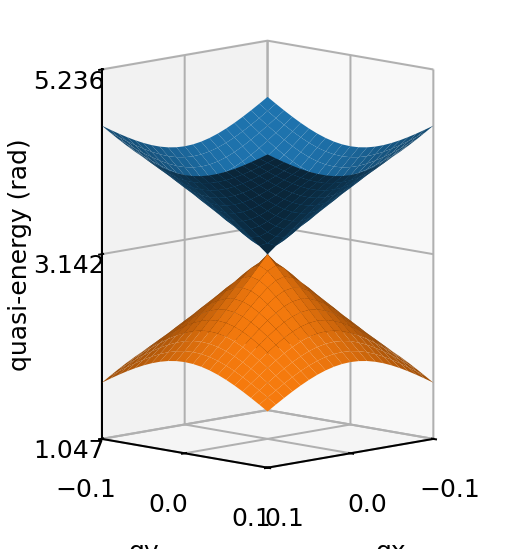

In [7]:

# 相位 -> 准能量
phases = -np.angle(Energy)#+ 2*np.pi          # (Nx, Ny, 1, 2)
phases = np.sort(phases, axis=-1)
ph = phases[:, :, 0, :].copy()

QX, QY = np.meshgrid(qx, qy, indexing='ij')   # (Nx, Ny)

# 提高清晰度：增大 dpi；曲面抗锯齿；去掉透明度
fig = plt.figure(figsize=(6, 3), dpi=180)
ax = fig.add_subplot(111, projection='3d')

surf0 = ax.plot_surface(QX, QY, ph[:, :, 0]+2*np.pi,
                        rstride=1, cstride=1,
                        linewidth=0, antialiased=True,
                        alpha=1.0, color='C0')
surf1 = ax.plot_surface(QX, QY, ph[:, :, 1],
                        rstride=1, cstride=1,
                        linewidth=0, antialiased=True,
                        alpha=1.0, color='C1')

# 视角 & 轴范围
ax.view_init(elev=10, azim=45)
ax.set_xlim(-0.1, 0.1); ax.set_ylim(-0.1, 0.1);  ax.set_zlim(-2*np.pi/3+np.pi, 2*np.pi/3+np.pi)
# 刻度：按要求设置
ax.set_xticks([-0.1, 0.0, 0.1])
ax.set_yticks([-0.1, 0.0, 0.1])
ax.set_zticks([-2*np.pi/3+np.pi,np.pi, 2*np.pi/3+np.pi])

# 标签
ax.set_xlabel('qx'); ax.set_ylabel('qy'); ax.set_zlabel('quasi-energy (rad)')

# “更方正”：等比例 + 正交投影（无透视压缩，更清晰）
ax.set_box_aspect((0.5, 0.5, 0.8))
ax.set_proj_type('ortho')

# 字体和边距微调
ax.tick_params(labelsize=10, pad=2)
plt.tight_layout()
#plt.savefig('QuasiEnergy.svg')
plt.show()

In [8]:
Nx, Ny = len(qx), len(qy)
phi_lo = ph[:, :, 0].copy()   # (Nx,Ny)
phi_hi = ph[:, :, 1].copy()   # (Nx,Ny)

# 你说的：只对下能带 + 2π（按你的需求来）
phi_lo = phi_lo + 2*np.pi

# 生成网格并展平
QX, QY = np.meshgrid(qx, qy, indexing="ij")   # (Nx,Ny)
data = np.column_stack([
    QX.ravel(),
    QY.ravel(),
    phi_lo.ravel(),
    phi_hi.ravel(),
])

np.savetxt(
    "Fig2(b).txt",
    data,
    delimiter="\t",
    fmt="%.10e",
    header="qx\tqy\tEnergy_lower\tEnergy_upper",
    comments=""
)
